# Apply Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner


**Note:** This script applies a **pretrained flight condition normalization pipeline**
to both **development (training)** and **test** datasets.  
No model training is performed her. The pipeline is loaded and applied unchanged.

In [116]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from src.pipelines.ocnorm import EstimationPipeline

## Configuration

In [117]:
data_name = "DS05"

In [118]:
# Paths
experiment_dir = Path('experiments')/data_name
opcond_dir = experiment_dir/'opcond'
data_split = 'dev'#'test' #

## 1. Load dataset

In [119]:
df = pd.read_csv(experiment_dir/f'data_{data_split}.csv',dtype={"Fc": str})

## Load the pipeline

In [120]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,q_low=0.01, q_high=0.99)


,oc_pipe,Pipeline(step...tart=False))])
,residual_aggregator,"OperCondResid...PC', 'SmHPC'])"
,hi_transformer,"HealthIndexTr...PC', 'SmHPC'])"
,hs_col,'hs'
,metrics,"['T48', 'SmFan', ...]"
,cycle_col,'cycle'
,q_low,0.01
,q_high,0.99
,corr_thresh,0.6
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'


## Apply pipeline

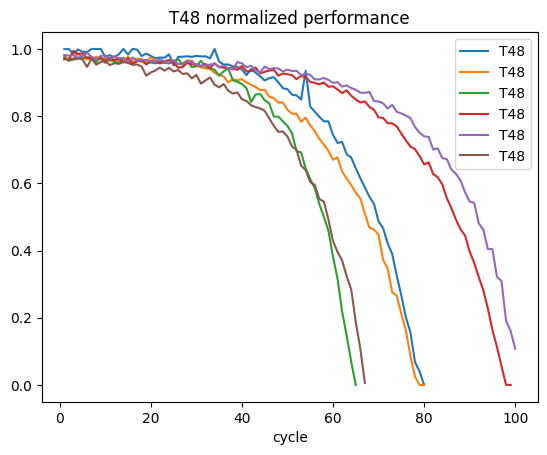

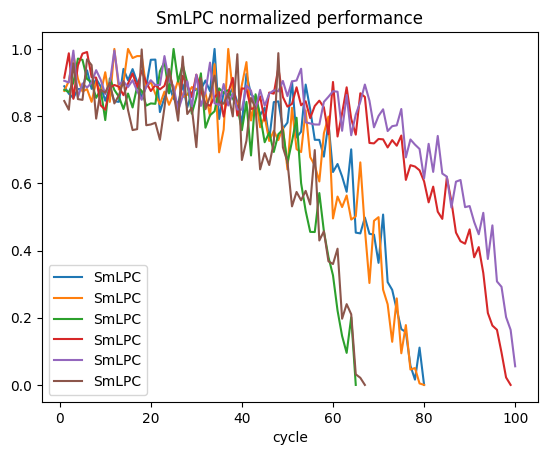

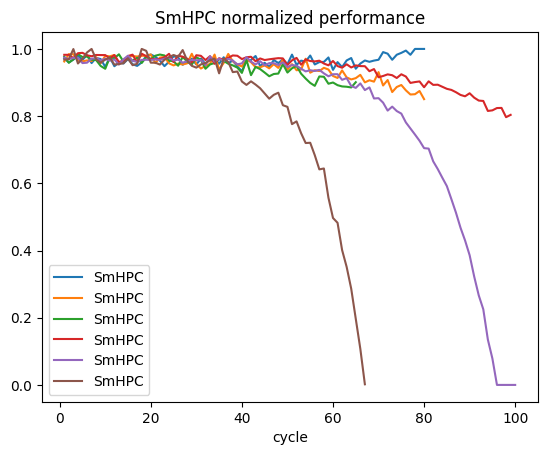

In [121]:
df_hi = pipe.transform(df)
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} normalized performance")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)

## Save hi data

In [122]:
df_hi = df_hi[['unit']+['cycle']+ pipe.get_performances()]

df_cycle = df.drop_duplicates(subset=["unit","cycle"], keep="last")
df_hi['hs'] = df_cycle['hs'].values 

In [123]:
df_hi.to_csv(experiment_dir/f'hidata_{data_split}.csv', index=False)